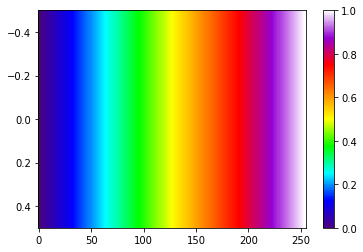

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pyvista as pv

# Définir les couleurs du bas au haut de la colormap de l'image
colors = [
    (75/255, 0, 130/255),   # indigo
    (0, 0, 255/255),        # bleu
    (0, 255/255, 255/255),  # cyan
    (0, 255/255, 0),        # vert
    (255/255, 255/255, 0),  # jaune
    (255/255, 127/255, 0),  # orange
    (255/255, 0 , 0),        # rouge
    (148/255, 0, 211/255),  # violet
    (1, 1, 1)               # blanc

]

cmap_name = 'custom_gradient'

# Créer la colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


# Afficher la colormap dans Matplotlib
plt.imshow(np.linspace(0, 1, 256)[None, :], aspect='auto', cmap=custom_cmap)
plt.colorbar()
plt.show()


In [2]:
import os
import feelpp
from feelpp.toolboxes.cfpdes import *
from tools.lap2D_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain
from tools.GeoToMsh import geo_to_msh
from tools.GmeshRead import mesh2d

import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import itertools
import torch
from pathlib import Path

class Poisson:
  """
  Solves the problem
  -Laplacian u = f   in Omega
  u            = g   in boundary
  
  - with f,g are set by the user
  """
  def __init__(self, dim=2, order=1):

    self.dim   = dim
    self.model = dict()
    self.order = order  
##______________________________________________________________________________________________

  def genCube(self, filename, h=0.1):
    """
    Generate a cube geometry following the dimension  self.dim
    """

    
    geo="""SetFactory("OpenCASCADE");
    h={};
    dim={};
    """.format(h, self.dim)
    
    if self.dim==2 :
      geo+="""
      Rectangle(1) = {0, 0, 0, 1, 1, 0};
      Characteristic Length{ PointsOf{ Surface{1}; } } = h;
      Physical Curve("Gamma_D") = {1,2,3,4};
      Physical Surface("Omega") = {1};
      """
    elif self.dim==3 :
      geo+="""
      Box(1) = {0, 0, 0, 1, 1, 1};
      Characteristic Length{ PointsOf{ Volume{1}; } } = h;
      Physical Surface("Gamma_D") = {1,2,3,4,5,6};
      Physical Volume("Omega") = {1};
      """
    with open(filename, 'w') as f:
      f.write(geo)

##______________________________________________________________________________________________

  def getMesh(self, filename,hsize=0.05,dim=2,verbose=False):
    """create mesh

    Args:
        filename (str): name of the file
        hsize (float): mesh size
        dim (int): dimension of the mesh
        verbose (bool): verbose mode
    """
    import os
    for ext in [".msh",".geo"]:
      f=os.path.splitext(filename)[0]+ext
      if os.path.exists(f):
        os.remove(f)
    if verbose:
      print(f"generate mesh {filename} with hsize={hsize} and dimension={dim}")
    self.genCube(filename=filename, h=hsize)
    mesh = feelpp.load(feelpp.mesh(dim=dim,realdim=dim), filename, hsize)
    return mesh

##______________________________________________________________________________________________

  def feel_solver(self, filename, h, json, dim=2,verbose=False):
    if verbose:
      print(f"Solving the laplacian problem for hsize = {h}...")
    feelpp_mesh = feelpp.load(feelpp.mesh(dim=self.dim, realdim=self.dim), filename, h)
    self.pb.setMesh(feelpp_mesh)    
    self.pb.setModelProperties(json)
    self.pb.init(buildModelAlgebraicFactory=True)
    self.pb.printAndSaveInfo()
    self.pb.solve()
    self.pb.exportResults()
    measures = self.pb.postProcessMeasures().values()
    return measures
  
##______________________________________________________________________________________________

  def scimba_solver(self, filename, h, json, dim = 2, verbose=False):
    if verbose:
      print(f"Solving a Poisson problem for hsize = {h}...")    
    if filename == '/workspaces/2024-m1-scimba-feelpp/geo/disk.geo':
      diff = self.diff.replace('{', '(').replace('}', ')')
      xdomain = domain.SpaceDomain(2, domain.DiskBasedDomain(2, center=[0.0, 0.0], radius=1.0))
      pde = PoissonDisk2D(xdomain, rhs=self.rhs, diff=diff, g=self.g, u_exact=self.u_exact)
      network, pde = Run_laplacian2D(pde)

    else:
      diff = self.diff.replace('{', '(').replace('}', ')')
      xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
      pde = Poisson_2D(xdomain, rhs=self.rhs, diff=diff, g=self.g, u_exact=self.u_exact)
      network, pde = Run_laplacian2D(pde)
  

    # Extract solution function u
    u = network.forward

    return u

##______________________________________________________________________________________________
  
  def __call__(self,
               h=0.05,                                       # mesh size 
               order=1,                                     # polynomial order 
               name='u',                                    # name of the variable u
               rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)',       # right hand side
               diff='{1,0,0,1}',                            # diffusion matrix
               g='0',                                       # boundary conditions    
               geofile=None,                                # domain
               plot=1,                                   # plot filename
               solver='feelpp',                             # solver 
               u_exact='sin(2 * pi * x) * sin(2 * pi * y)',
               grad_u_exact = '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}' 
               ):
    """
    Solves the problem where :
    - h is the mesh size
    - order the polynomial order
    - rhs is the expression of the right-hand side f(x,y)
    """
    self.measures = dict()
    self.rhs = rhs
    self.g = g
    self.u_exact = u_exact
    self.diff = diff
    self.pb    = cfpdes(dim=self.dim, keyword=f"cfpdes-{self.dim}d-p{self.order}")
    self.model = {
      "Name": "Poisson",
      "ShortName": "Poisson",
      "Models":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "equations":"poisson"
        },
        "poisson":{
          "setup":{
            "unknown":{
              "basis":f"Pch{order}",
              "name":f"{name}",
              "symbol":"u"
            },
            "coefficients":{
              "c": f"{diff}:x:y" if self.dim == 2 else f"{diff}:x:y:z",
              "f": f"{rhs}:x:y"  if self.dim == 2 else f"{rhs}:x:y:z"
            }
          }
        }
      },
      "Materials":
      {
        "Omega":
        {
          "markers":["Omega"]
        }
      },
      "BoundaryConditions":
      {
        "poisson":
        {
          "Dirichlet":
          {
            "g":
            {
              "markers":["Gamma_D"],
              "expr":f"{g}:x:y"
            }
          }
        }
      },
      "PostProcess":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "Exports":
          {
            "fields":["all"],
            "expr":{
              #"u_scimba": f"{name}:x:y" if self.dim == 2 else f"{name}:x:y:z",
              "rhs": f"{rhs}:x:y" if self.dim == 2 else f"{rhs}:x:y:z",
              "u_exact" : f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
              "grad_u_exact" : f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
            }
          },
            "Measures" :
            {
              "Norm" :
              {
                  "poisson" :
                  {
                     "type":["L2-error", "H1-error"],
                     "field":f"poisson.{name}",
                     "solution": f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
                     "grad_solution": f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
                     "markers":"Omega",
                     "quad":6
                 }
              },
                "Statistics":
                {
                    "mystatA":
                    {
                        "type":["min","max","mean","integrate"],
                        "field":f"poisson.{name}"
                    }
                }
            }
        }
      }
    }

    fn = None
    if geofile is None:
      fn = f'omega-{self.dim}.geo'
      self.genCube(fn, h)
    else:
      fn = geofile      
##________________________

  # Solving

    self.measures = self.feel_solver(filename=fn, h=h, json=self.model, dim=self.dim, verbose=True)
      
    if solver == 'scimba':
      u_scimba = self.scimba_solver(filename=fn, h=h, json=self.model, dim=self.dim, verbose=True)
      print('solution = ', u_scimba)
      # Get mesh points
      geo_to_msh(fn, f"omega-{self.dim}d.msh", mesh_size=h)
      mesh = f"omega-{self.dim}d.msh"
      my_mesh = mesh2d(mesh)
      my_mesh.read_mesh()
      coordinates = my_mesh.Nodes

      # Evaluate the network on mesh points
      input_tensor = torch.tensor(coordinates, dtype=torch.double)
      mu = torch.tensor([[0.5]]).repeat(input_tensor.size(0), 1)  # Example mu values
      solution_tensor = u_scimba(input_tensor, mu)

      # Define a lambda function to represent u_scimba with 'x' and 'y' as variables
      u_scimba_xy = lambda x, y: u_scimba(torch.tensor([x, y], dtype=torch.double), mu)

      # Convert the tensor to a NumPy array
      solution_array = solution_tensor.detach().numpy()
##________________________

     
    # Plots
    if plot != None:
      
      from xvfbwrapper import Xvfb
      import pyvista as pv 
      import matplotlib.pyplot as plt


      vdisplay = Xvfb()
      vdisplay.start()
      pv.set_jupyter_backend('static') 
      #pv.start_xvfb()
      def pv_get_mesh(mesh_path):
        reader = pv.get_reader(mesh_path)
        mesh = reader.read()
        return mesh

      def pv_plot(mesh, field, clim=None, cmap=custom_cmap, cpos='xy', show_scalar_bar=True, show_edges=True):
        mesh.plot(scalars=field, clim=clim, cmap=cmap, cpos=cpos, show_scalar_bar=show_scalar_bar, show_edges=show_edges)

      def myplots(dim=2, field=f"cfpdes.poisson.{name}", factor=1, cmap=custom_cmap):
        mesh = pv_get_mesh((f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case"))
        #pv_plot(mesh, field)
        pl = pv.Plotter(shape=(1,2))
        if solver == 'scimba':
          pl = pv.Plotter(shape=(1,3))
          pl.subplot(0,2)
          pl.add_title('u_scimba=', font_size=10)
          pl.add_mesh(mesh[0].copy(), scalars = solution_array, cmap=custom_cmap)
          

        pl.subplot(0,0)
        pl.add_title(f'Solution P{order}', font_size=18)
        pl.add_mesh(mesh[0], scalars = f"cfpdes.poisson.{name}", cmap=custom_cmap)

        pl.subplot(0,1)
        pl.add_title('u_exact=' + u_exact, font_size=10)
        pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.u_exact', cmap=custom_cmap)

        

        pl.link_views()
        pl.view_xy()
        pl.show()
        pl.screenshot(plot)
          
      myplots(dim=2,factor=0.5)  

Using device: cpu
torch loaded; device is cpu


In [3]:
import sys
import feelpp
import feelpp.toolboxes.core as tb

# mandatory things
sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h



[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-Jun-06
[feelpp] create Feel++ root repository: /workspaces/2024-m1-scimba-feelpp/feelppdb

[feelpp] create Feel++ geo repository: /workspaces/2024-m1-scimba-feelpp/feelppdb/geo

[feelpp] create Feel++ results directory: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1

[feelpp] create Feel++ expressions directory: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/exprs

[feelpp] create Feel++ logs directory: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/logs

 . feelpp_app files are stored in /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/logs


Solving the laplacian problem for hsize = 0.05...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                                                |
| | Environment                 

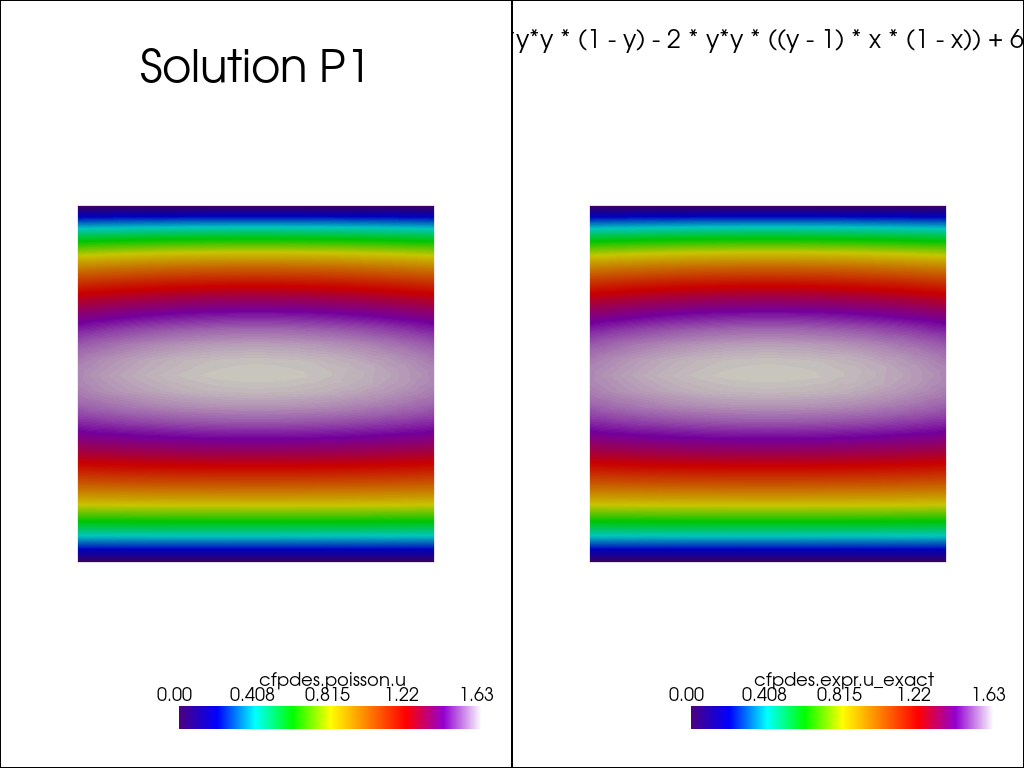

Solving the laplacian problem for hsize = 0.05...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                                                |
| | Environment                 

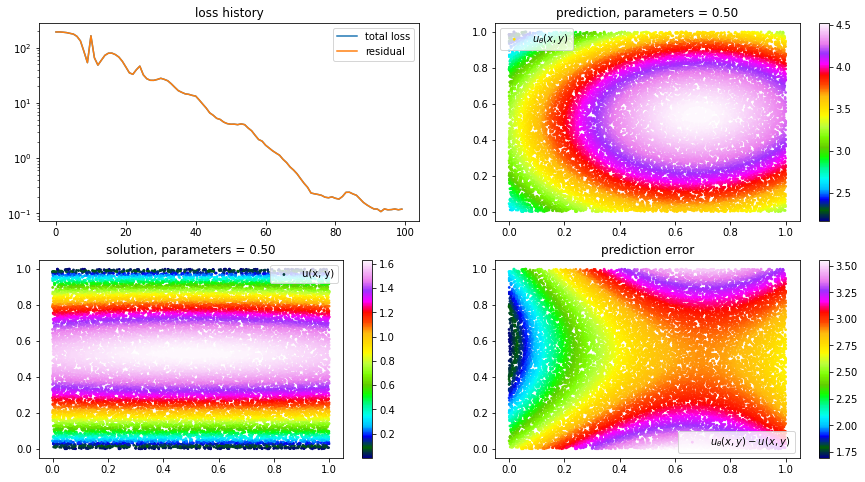

solution =  <bound method MLP_x.forward of MLP_x(
  (net): GenericMLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=3, out_features=20, bias=True)
      (1-4): 4 x Linear(in_features=20, out_features=20, bias=True)
    )
    (output_layer): Linear(in_features=20, out_features=1, bias=True)
    (activation_output): Id()
  )
)>
Info    : Reading 'omega-2.geo'...
Info    : Done reading 'omega-2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000694026s, CPU 0.000374s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0157992s, CPU 0.013641s)
Info    : 514 nodes 1030 elements
Info    : Writing 'omega-2d.msh'...
Info    : Done writing 'omega-2d.msh'


ValueError: Number of scalars (514) must match either the number of points (517) or the number of cells (952).

In [4]:
u_exact = 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)'
rhs='-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y))'

P = Poisson(dim = 2)
P(rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', u_exact = u_exact)
P(rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', solver='scimba', u_exact = u_exact)
print(P.measures)


In [ ]:
def runLaplacianPk(P, df, model, verbose=False):
    """Generate the Pk case"""
    meas = dict()
    dim, order, json = model
    fn = f'omega-{P.dim}.geo'
    
    for h in df['h']:
        m = P.measures #P.feel_solver(filename=fn, h=h, json=json, dim=dim, verbose=verbose)
        if m is None:
            print(f"Warning: Solver returned None for h={h}")
            continue

        for norm in ['L2', 'H1']:
            error_key = f'Norm_poisson_{norm}-error'
            if error_key not in m:
                print(f"Warning: '{error_key}' not found in solver output")
                continue

            meas.setdefault(f'P{order}-Norm_poisson_{norm}-error', [])
            meas[f'P{order}-Norm_poisson_{norm}-error'].append(m[error_key])

    df = df.assign(**meas)

    # Calculate convergence rates where possible
    for norm in ['L2', 'H1']:
        error_series = f'P{order}-Norm_poisson_{norm}-error'
        if error_series in df and len(df[error_series]) > 1:
            rate_series = f'P{order}-poisson_{norm}-convergence-rate'
            rates = np.log2(df[error_series].shift() / df[error_series]) / np.log2(df['h'].shift() / df['h'])
            df[rate_series] = rates.fillna(0)  # Replace NaNs with zero or another suitable value

    return df
def runConvergenceAnalysis(P, json,dim=2,hs=[0.1,0.05,0.025],order='1',verbose=False):
  df=pd.DataFrame({'h':hs})
  df=runLaplacianPk(P, df=df,model=[dim,order,json(dim=dim,order=order)],verbose=verbose)
  print(df.to_markdown())
  return df

#laplacian_json = lambda order,dim=2,name="u": P.model
#df= runConvergenceAnalysis(P, json=laplacian_json,dim=2,verbose=True)



def plot_convergence(P, df,dim,orders=[1]):
  fig=px.line(df, x="h", y=[f'P{order}-Norm_poisson_{norm}-error' for order,norm in list(itertools.product(orders,['L2','H1']))])
  fig.update_xaxes(title_text="h",type="log")
  fig.update_yaxes(title_text="Error",type="log")
  for order,norm in list(itertools.product(orders,['L2','H1'])):
    fig.update_traces(name=f'P{order} - {norm} error - {df[f"P{order}-poisson_{norm}-convergence-rate"].iloc[-1]:.2f}', selector=dict(name=f'P{order}-Norm_poisson_{norm}-error'))
  fig.update_layout(
          title=f"Convergence rate for the {dim}D Laplacian problem",
          autosize=False,
          width=900,
          height=900,
      )
  return fig
#fig= plot_convergence(P, df,dim=2)
#fig.show()



In [ ]:

u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, u_exact = u_exact)

poisson_json = lambda order,dim=2,name="u": P.model

model=[P.dim,P.order,poisson_json(dim=P.dim,order=P.order)]
print(model)
hs=[0.1,0.05,0.025,0.0125]
df=pd.DataFrame({'h':hs})


df= runLaplacianPk(P, df=df, model=model, verbose=True)
df= runConvergenceAnalysis( P, json=poisson_json,dim=2,verbose=True)


In [ ]:
fig= plot_convergence(P, df,dim=2)
fig.show()



In [ ]:



# 2D on different domains
P = Poisson(dim = 2)

# for disk domain
u_exact =  'sin(pi*(x*x + y*y))'
rhs = '4* pi * (-cos(pi* (x*x + y*y)) + pi * (x*x + y*y)* sin(pi* (x*x + y*y)))'
P(rhs=rhs, g='0', order=1, geofile='/workspaces/2024-m1-scimba-feelpp/geo/disk.geo', solver='feelpp', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, geofile='/workspaces/2024-m1-scimba-feelpp/geo/disk.geo', solver='scimba', u_exact = u_exact)

# for square domain
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, solver='feelpp', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, solver ='scimba', u_exact = u_exact)






In [ ]:

u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
P(rhs='5/2', g='y',solver='feelpp', u_exact = u_exact)
P(rhs='5/2', g='y', solver ='scimba', u_exact = u_exact)

u_exact = '-y*y/2 - x*y*y*y/2 + y*y*y*y/4'

P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', order=1, solver='feelpp')
P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', order=1, solver ='scimba')




In [ ]:


# # 2D with varying anisotropy
P = Poisson(dim = 2)
u_exact = 'x*x/(1+x) + y*y/(1+y)'
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='feelpp', u_exact = u_exact)
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='scimba', u_exact = u_exact)

P(rhs='4', diff='{x,y,-y,x+y}', g='x*x/(1+x) + y*y/(1+y)',  solver='feelp')
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)',  solver='scimba')

